## Perform energy yield assessment (EYA)-operational assessment (OA) gap analysis

This notebook will explore the use of the energy yield assessment (EYA) gap analysis method in OpenOA. This method attributes differences in an EYA-estimate and an operational assessment (OA) estimate of annual energy production (AEP; or net energy, P50). Differences in availability loss estimates, electrical loss estimates, and turbine ideal energy estimates are analyzed. The latter metric incorporates many aspects of an EYA, including the wind resource estimate, wake loss estimate, turbine performance, and blade degradation. 

The gap analysis is based on comparing the following three key metrics:

1. Availability loss
2. Electrical loss
3. Sum of turbine ideal energy
        
Here turbine ideal energy is defined as the energy produced during 'normal' or 'ideal' turbine operation, 
i.e., no downtime or considerable underperformance events. This value encompasses several different aspects 
of an EYA (wind resource estimate, wake losses, turbine performance, and blade degradation) and in most cases
should have the largest impact in a gap analysis relative to the first two metrics.
    
This gap analysis method is fairly straighforward. Relevant EYA and OA metrics are passed in when defining
the class, differences in EYA estimates and OA results are calculated, and then a 'waterfall' plot is created
showing the differences between the EYA and OA-estimated AEP values and how they are linked from differences in 
the three key metrics.
    
Waterfall plot code was taken and modified from the following post: https://pbpython.com/waterfall-chart.html

In [1]:
# Import required packages
from openoa.analysis import MonteCarloAEP, TurbineLongTermGrossEnergy, ElectricalLosses, EYAGapAnalysis

import project_ENGIE

ImportError: cannot import name 'Project_Engie' from 'project_ENGIE' (/Users/rhammond/Documents/GitHub/OpenOA/examples/project_ENGIE.py)

In [2]:
# Load plant object and process plant data
project = Project_Engie('./data/la_haute_borne')
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:openoa.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:openoa.types.timeseries_table:Loading name:plant_data
INFO:openoa.types.timeseries_table:Loading name:plant_data
INFO:openoa.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:openoa.types.timeseries_table:Loading name:era5_wind_la_haute_borne


### Calculate AEP, TIE, and electrical losses from operational data

The first step is to calculate annual energy production (AEP) for the wind farm (Example 02), turbine ideal energy (TIE) for the wind farm (Example 03) and calculate electrical losses (Example 04). Please refer to detailed documentation of these methods in the previous example notebooks. 

In [3]:
# Calculate AEP
pa = plant_analysis.MonteCarloAEP(project, reanal_products = ['era5', 'merra2'])
pa.run(num_sim=20000, reanalysis_subset=['era5', 'merra2'])

INFO:openoa.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:openoa.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 20000, 'reanalysis_subset': ['era5', 'merra2']}
100%|██████████| 20000/20000 [04:57<00:00, 67.32it/s] 
INFO:openoa.methods.plant_analysis:Run completed


In [4]:
# Calculate TIE
ta = turbine_long_term_gross_energy.TurbineLongTermGrossEnergy(project, UQ=False)
ta.run(reanalysis_subset = ['era5', 'merra2'], 
       max_power_filter = 0.85, 
       wind_bin_thresh = 2.0,
       correction_threshold = 0.90, 
       enable_plotting = False,
       plot_dir = None)

INFO:openoa.methods.turbine_long_term_gross_energy:Initializing TurbineLongTermGrossEnergy Object
INFO:openoa.methods.turbine_long_term_gross_energy:Note: uncertainty quantification will NOT be performed in the calculation
INFO:openoa.methods.turbine_long_term_gross_energy:Processing SCADA data into dictionaries by turbine (this can take a while)
  0%|          | 0/2 [00:00<?, ?it/s]INFO:openoa.methods.turbine_long_term_gross_energy:Filtering turbine data
INFO:openoa.methods.turbine_long_term_gross_energy:Processing reanalysis data to daily averages
INFO:openoa.methods.turbine_long_term_gross_energy:Processing scada data to daily sums

0it [00:00, ?it/s]
4it [00:00, 37.63it/s]
INFO:openoa.methods.turbine_long_term_gross_energy:Setting up daily data for model fitting
INFO:openoa.methods.turbine_long_term_gross_energy:Fitting model data
INFO:openoa.methods.turbine_long_term_gross_energy:Applying fitting results to calculate long-term gross energy
 50%|█████     | 1/2 [00:01<00:01,  1.69s

In [5]:
# Calculate electrical losses
el = electrical_losses.ElectricalLosses(project)
el.run()

INFO:openoa.methods.electrical_losses:Initializing Electrical Losses Object
INFO:openoa.methods.electrical_losses:Note: uncertainty quantification will NOT be performed in the calculation
INFO:openoa.methods.electrical_losses:Processing SCADA data
INFO:openoa.methods.electrical_losses:Processing meter data
INFO:openoa.methods.electrical_losses:Calculating electrical losses
100%|██████████| 1/1 [00:00<00:00, 110.73it/s]


Now that we've calculated the key operational metrics, we setup some arrays that the gap analysis method needs to run.

### Summarize operational results and create EYA data for comparison

In [6]:
# First summarize key operational results
aep = pa.results.aep_GWh.mean()
avail = pa.results.avail_pct.mean()
elec = el._electrical_losses[0][0]
tie = ta._plant_gross[0][0]/1e6

print(aep, avail, elec, tie)

12.286455368458357 0.011708000696263628 0.019994645742960393 13.542669137731394


In [7]:
# Define operational data list
oa_list = [aep, avail, elec, tie] 
# AEP (GWh/yr), availability loss (fraction), electrical loss (fraction), turbine ideal energy (GWh/yr)

# Define EYA data list (we are fabricating these values here as an example)
eya_list = [16.46, 20., 0.04, 0.014, 0.037, 0.011, 0.087] 
# AEP (GWh/yr), Gross energy (GWh/yr), availability loss (fraction), electrical loss (fraction), turbine performance loss (fraction)
# blade degradation loss (fraction), wake loss (fraction)

### Perform gap analysis

Now that we have the data we need, we first create a gap analysis object

In [8]:
gap_anal = eya_gap_analysis.EYAGapAnalysis(plant = 'La Haute Borne', eya_estimates = eya_list, oa_results = oa_list)

INFO:openoa.methods.eya_gap_analysis:Initializing EYA Gap Analysis Object


Now we run the analysis, which by default outputs a waterfall plot showing how the gap between EYA-reported AEP and plant-measured AEP can be explained:

INFO:openoa.methods.eya_gap_analysis:Gap analysis complete


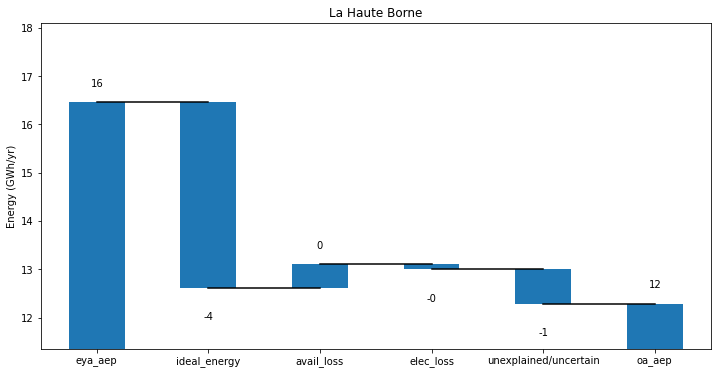

In [9]:
gap_anal.run()

In this example, they EYA estimate of AEP was about 4 GWh/yr higher than the OA result. This difference is largely explained by a large difference in turbine ideal energy (overestimated in EYA), and smaller differences in availability (underestimated in EYA) and electrical losses (overestimated in EYA). A total of 1 GWh/yr is left unexplained or uncertain using this method.